In [82]:
!pip install nevergrad

import sqlite3 as db
import pandas as pd
import json
import time
import statistics as stat
import random

import matplotlib.pyplot as plt
import seaborn as sns
import nevergrad as ng

from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor

<center><h2><b>Leer DB</b></h2></center>

Primero de todo leemos la base de datos en un dataframe. Hemos limpiado cada tabla individualmente y las hemos juntado con LEFT JOIN para que no se pierda<br>
ninguna información de la tabla principal que es pacient.

In [83]:
def sql_query(q):
    conn = db.connect('../db/sqlite/eicu_v2_0_1_clean.sqlite3')
    df = pd.read_sql_query(q, conn)
    conn.close()
    
    return df

In [84]:
X_query = """
    SELECT *
    FROM patient P LEFT JOIN diagnosis                    D ON P.patientunitstayid = D.patientunitstayid
                   LEFT JOIN admissiondrug               AD ON P.patientunitstayid = AD.patientunitstayid
                   LEFT JOIN respiratoryCare             RC ON P.patientunitstayid = RC.patientunitstayid
                   LEFT JOIN physicalExam                PE ON P.patientunitstayid = PE.patientunitstayid
                   LEFT JOIN admissionDx                ADX ON P.patientunitstayid = ADX.patientunitstayid
                   LEFT JOIN carePlanCareProvider         C ON P.patientunitstayid = C.patientunitstayid
                   LEFT JOIN carePlanGeneral             CG ON P.patientunitstayid = CG.patientunitstayid
                   LEFT JOIN carePlanInfectiousDisease CGID ON P.patientunitstayid = CGID.patientunitstayid
                   LEFT JOIN carePlanGoal               CPG ON P.patientunitstayid = CPG.patientunitstayid
                   LEFT JOIN vitalAperiodic             VAP ON P.patientunitstayid = VAP.patientunitstayid
                   LEFT JOIN vitalPeriodic               VP ON P.patientunitstayid = VP.patientunitstayid
                   LEFT JOIN medication                   M ON P.patientunitstayid = M.patientunitstayid
                   LEFT JOIN allergy                     AL ON P.patientunitstayid = AL.patientunitstayid
                   LEFT JOIN infusiondrug                ID ON P.patientunitstayid = ID.patientunitstayid
"""

X = sql_query(X_query).drop(columns=['patientunitstayid'])
y = X['unitdischargeoffset']

X['apacheadmissiondx'] = X['apacheadmissiondx'].fillna('_Unknown')

<center><h2><b>Sanear valores dejados a NaN del Left Join</b></h2></center>

Al hacer Left Join nos quedan campos nulos. Dependiendo del tipo de datos y de los otros datos de cada columna en particular<br>
los rellenamos con 0, -1 o un string indicando falta de valor.

In [85]:
# admissiondrug
X['currenthistoryseqnum'] = X['currenthistoryseqnum'].fillna('_Unknown')
for col in ['ASPIRIN', 'LISINOPRIL', 'LASIX']:
    X[col] = X[col].fillna(0.0)

# physicalExam
for col in ['BPD_Current', 'BPD_Highest', 'BPD_Lowest', 'BPS_Current', 'BPS_Highest', 'BPS_Lowest', 'Blood_Loss', 'Dialysis_Net', 'O2Sat_Current',
            'O2Sat_Highest', 'O2Sat_Lowest', 'Urine', 'Intubated', 'Comatose', 'Ventilated', 'Motor', 'Verbal', 'Eyes']:
    X[col] = X[col].fillna(-1)

# admissionDx
for col in ['Cardiovascular', 'Respiratory', 'Neurologic']:
    X[col] = X[col].fillna(0)

# carePlanGoal
for col in ['Care_Patient_Family', 'Care_Pulmonary', 'Care_Fluid_Balance_Treatments', 'Care_Activity_Safety',
            'Care_Cardiovascular', 'Care_Infection_Labs']:
    X[col] = X[col].fillna(0)

# carePlanCareProvider
for col in ['Categoria_Hospital', 'Categoria_Cardiology', 'Categoria_Internal_Medicine', 'Intervencion_I', 'Intervencion_II', 'Intervencion_III', 'Intervencion_IV']:
    X[col] = X[col].fillna(0)

# carePlanGeneral
for col in ['Categoria_Ventilacion', 'Categoria_DVT_Prophylaxis', 'Categoria_Airway', 'Categoria_Care_Limitation', 'Categoria_Stress_Ulcer_Prophylaxis']:
    X[col] = X[col].fillna(0)

# carePlanInfectiousDisease
for col in ['infectdiseasesite', 'infectdiseaseassessment']:
    X[col] = X[col].fillna('_None')

# vitalAperiodic
X['last_aperiodic_off'] = X['last_aperiodic_off'].fillna(-1)
for col in ['last_aperiodic_systolic', 'last_aperiodic_diastolic', 'last_aperiodic_mean']:
    X[col] = X[col].fillna(X[col].median())
    
# vitalPeriodic
for col in ['temperature', 'sao2', 'respiration', 'cvp', 'heartrate']:
    X[col] = X[col].fillna(X[col].median())

# Medication
X['last_order_offset'] = X['last_order_offset'].fillna(-1)

# Allergy
for col in ['nDrugsAllergic', 'nNondrugsAllergic', 'totalAllergic']:
    X[col] = X[col].fillna(0)
    X[col] = X[col].astype('int32')
    
# Diagnosis
for col in ['last1', 'last2', 'last3', 'last4']:
    X[col] = X[col].fillna('_Unknown')
for col in ['last1_off', 'last2_off', 'last3_off', 'last4_off']:
    X[col] = X[col].fillna(-1)

# InfusionDrug
X['lastInfusionDrugOffset'] = X['lastInfusionDrugOffset'].fillna(-1)

Tras el paso anterior, este es el dataset resultante:

In [86]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 400)
X.head(10)

,gender,age,ethnicity,hospitalid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,unitvisitnumber,admissionweight,unitdischargeoffset,avg_unit_stay,avg_hospital_stay,admission_bmi,last1,last2,last3,last4,last1_off,last2_off,last3_off,last4_off,ASPIRIN,LISINOPRIL,LASIX,currenthistoryseqnum,BPD_Current,BPD_Highest,BPD_Lowest,BPS_Current,BPS_Highest,BPS_Lowest,Blood_Loss,Dialysis_Net,O2Sat_Current,O2Sat_Highest,O2Sat_Lowest,Urine,Intubated,Comatose,Ventilated,Motor,Verbal,Eyes,Cardiovascular,Respiratory,Neurologic,Categoria_Hospital,Categoria_Cardiology,Categoria_Internal_Medicine,Intervencion_I,Intervencion_II,Intervencion_III,Intervencion_IV,Categoria_Ventilacion,Categoria_DVT_Prophylaxis,Categoria_Airway,Categoria_Care_Limitation,Categoria_Stress_Ulcer_Prophylaxis,infectdiseasesite,infectdiseaseassessment,Care_Patient_Family,Care_Pulmonary,Care_Fluid_Balance_Treatments,Care_Activity_Safety,Care_Cardiovascular,Care_Infection_Labs,last_aperiodic_off,last_aperiodic_systolic,last_aperiodic_diastolic,last_aperiodic_mean,temperature,sao2,respiration,cvp,heartrate,last_order_offset,nDrugsAllergic,nNondrugsAllergic,totalAllergic,lastInfusionDrugOffset
0,Female,87,Caucasian,59,nan,157.5,-2258,Emergency Department,366,2,67.60,344,0,0,-1.000000,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,334.0,153.0,78.0,103.0,-1.0,-1.0,-1.0,-1.0,-1.0,1486.0,0,0,0,-1.0
1,Female,87,Caucasian,59,"rhythm disturbance (atrial, supraventricular)",157.5,-8,Emergency Department,2616,1,46.50,2250,344,366,3.387097,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,1.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,14.0,14.0,14.0,242.0,899.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,2204.0,175.0,77.0,102.0,-1.0,-1.0,-1.0,-1.0,-1.0,1396.0,0,0,0,-1.0
2,Male,76,Caucasian,68,"endarterectomy, carotid",167.0,-1,Operating Room,1218,1,77.50,793,0,0,2.154839,s/p cartoid endarterectomy,bradycardia,coronary artery disease,None,10.0,10.0,10.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,13.0,10.0,13.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,754.0,107.0,54.0,78.0,-1.0,-1.0,-1.0,-1.0,-1.0,1033.0,0,0,0,-1.0
3,Female,34,Caucasian,56,"overdose, other toxin, poison or drug",172.7,-23,Emergency Department,1138,1,60.30,1121,0,0,2.864013,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,0.0,0.0,1.0,0.0,0.0,28.0,1.0,0.0,0.0,0.0,28.0,288.0,28.0,28.0,288.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,1043.0,124.0,70.0,93.0,-1.0,-1.0,-1.0,-1.0,-1.0,1013.0,0,0,0,-1.0
4,Male,61,Caucasian,68,"gi perforation/rupture, surgery for",177.8,-10,Emergency Department,5263,1,91.70,1369,0,0,1.938931,sepsis,sepsis,diverticulitis of colon,s/p exploratory laparotomy,330.0,167.0,13.0,167.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,6,5,4,0.0,0.0,0.0,0.0,0.0,153.0,1.0,1.0,0.0,0.0,14.0,139.0,14.0,14.0,153.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,1180.0,132.0,71.0,95.0,-1.0,-1.0,-1.0,-1.0,-1.0,3542.0,0,0,0,-1.0
5,Female,55,Caucasian,63,nan,157.5,-495,Operating Room,610,2,85.45,610,0,0,-1.000000,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,_None,_None,0.0,0.0,0.0,0.0,0.0,0.0,500.0,120.0,71.0,89.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,-1.0
6,Female,55,Caucasian,63,"endarterectomy, carotid",157.5,-19,Operating Room,1086,1,72.50,476,610,610,2.172414,_Unknown,_Unknown,_Unknown,_Unknown,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,_Unknown,-1.0,-1,-1,-1

<center><h2><b>Transformación de columnas</b></h2></center>

In [87]:
categs = {}

for col in ['gender', 'ethnicity', 'hospitalid', 'hospitaladmitsource', 'currenthistoryseqnum', 'infectdiseasesite', 'infectdiseaseassessment',
            'nDrugsAllergic', 'nNondrugsAllergic', 'totalAllergic']:
    categs[col] = list(set(X[col]))

In [88]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=234750)

No hemos puesto demasiada antención a la eliminación de outliers y normalización de columnas numéricas ya que nuestro principal regresor ha sido RandomForest. Hemos usado<br>
OneHot para las variables categóricas con un número limitado de columnas y directamente passthrough para las variables numéricas.

In [89]:
transformers = [
    # Patient
    ('gender',                  OneHotEncoder(categories=[categs['gender']]),  []),
    ('age',                     'passthrough',    []),
    ('ethnicity',               OneHotEncoder(categories=[categs['ethnicity']]),  []),
    ('hospitalid',              OneHotEncoder(categories=[categs['hospitalid']]),  []),
    ('apacheadmissiondx',       'drop',           []),
    ('admissionheight',         'passthrough',    []),
    ('hospitaladmitoffset',     'passthrough',    []),
    ('hospitaladmitsource',      OneHotEncoder(categories=[categs['hospitaladmitsource']]), []),
    ('hospitaldischargeoffset', 'drop',           []),
    ('unitvisitnumber',         'passthrough',    []),    
    ('admissionweight',         'passthrough',    []),
    ('unitdischargeoffset',     'drop',           []),
    ('_avg_unit_stay',          'passthrough',    []),
    ('_avg_hospital_stay',      'passthrough',    []),
    ('_admission_bmi',          'passthrough',    []),
    
    # Diagnosis
    ('_DIAGNOSIS_last1', 'drop', []),
    ('_DIAGNOSIS_last2', 'drop', []),
    ('_DIAGNOSIS_last3', 'drop', []),
    ('_DIAGNOSIS_last4', 'drop', []),


    ('_DIAGNOSIS_last1_off', 'passthrough', []),
    ('_DIAGNOSIS_last2_off', 'passthrough', []),
    ('_DIAGNOSIS_last3_off', 'passthrough', []),
    ('_DIAGNOSIS_last4_off', 'passthrough', []),
    
    # AdmissionDrug
    ('_admissionAspirin',    'passthrough', []),
    ('_admissionLisinopril', 'passthrough', []),
    ('_admissionLasix',      'passthrough', []),
    
    # RespCare
    ('currenthistoryseqnum', OneHotEncoder(categories=[categs['currenthistoryseqnum']]), []),
    
    # PhysicalExam
    # TODO
    ('a0', 'drop', []),
    ('a1', 'drop', []),
    ('a2', 'drop', []),
    ('a3', 'drop', []),
    ('a4', 'drop', []),
    ('a5', 'drop', []),
    ('a6', 'drop', []),
    ('a7', 'drop', []),
    ('a8', 'drop', []),
    ('a9', 'drop', []),
    ('b1', 'drop', []),    
    ('b2', 'drop', []),
    ('b3', 'drop', []),
    ('b4', 'drop', []),
    ('b5', 'drop', []),
    ('b6', 'drop', []),
    ('b7', 'drop', []),
    ('b8', 'drop', []),

    # AdmissionDx
    ('_admissionCardiovascular', 'passthrough',  []),
    ('_admissionRespiratory',    'passthrough',  []),
    ('_admissionNeurologic',     'passthrough',  []),
  
    # CarePlanProvider
    ('Categoria_Hospital',          'passthrough', []), 
    ('Categoria_Cardiology',        'passthrough', []),
    ('Categoria_Internal_Medicine', 'passthrough', []),
    ('Intervencion_I',              'passthrough', []),
    ('Intervencion_II',             'passthrough', []),
    ('Intervencion_III',            'passthrough', []), 
    ('Intervencion_IV',             'passthrough', []),
    
    # CarePlanGeneral
    ('Categoria_Ventilacion',              'passthrough', []),
    ('Categoria_DVT_Prophylaxis',          'passthrough', []),
    ('Categoria_Airway',                   'passthrough', []),
    ('Categoria_Care_Limitation',          'passthrough', []),
    ('Categoria_Stress_Ulcer_Prophylaxis', 'passthrough', []),
    
    # CarePlanInfectiousDisease
    ('infectdiseasesite',      OneHotEncoder(categories=[categs['infectdiseasesite']]), []),
    ('infectdiseaseassessment', OneHotEncoder(categories=[categs['infectdiseaseassessment']]), []),
    
    ('last_aperiodic_off',       'passthrough', []),
    ('last_aperiodic_systolic',  'passthrough', []),
    ('last_aperiodic_diastolic', 'passthrough', []),
    ('last_aperiodic_mean',      'passthrough', []),
    
    # vitalPeriodic
    ('VP_temp',        'passthrough', []),
    ('VP_sao2',        'passthrough', []),
    ('VP_respiration', 'passthrough', []),
    ('VP_cvp',         'passthrough', []),
    ('VP_heartrate',   'passthrough', []),

    # Medication
    ('last_order_offset', 'passthrough', []),
    
    # Allergy
    # TODO
    ('nDrugsAllergic',    'drop', []),#OneHotEncoder(categories=[categs['nDrugsAllergic']]), []),
    ('nNondrugsAllergic', 'drop', []),#OneHotEncoder(categories=[categs['nNondrugsAllergic']]), []),
    ('totalAllergic',     'drop', []),#OneHotEncoder(categories=[categs['totalAllergic']]), []),
    
    # TODO
    ('asdofibasodfboasdfdsf',  'passthrough', []),
    
]

# Numerar columnas para el tranformador
for i in range(len(transformers)):
    transformers[i][2].append(i)

# Transformar la matriz
X_T      = ColumnTransformer(transformers=transformers).fit_transform(X)
X_T_test = ColumnTransformer(transformers=transformers).fit_transform(X_test)

# Mostrar el cambio en columnas
print(X.shape, '->', X_T.shape)

(2277, 82) -> (2277, 267)


<center><h2><b>Busqueda de Hiperparametros</b></h2></center>

Hemos usado Nevergrad para buscar los hiperparámetros de RandomForest y XBoost mediante un algorítmo genético, ya que son una cantidad importante de hiperparámetros.<br>

In [90]:
# Número aleatorio para la búsqueda de hiperparámetros
rand_n = random.randint(0, 100000000000)

# Funcion auxiliar para devolver un conjunto de scores y su media y desviación estandar
def cv_avg_std(reg, X, y, scoring):
    maes = cross_val_score(reg, X, y, cv=5, scoring=scoring)
    avg = stat.mean(maes)
    std_dev = stat.variance(maes)**(1/2)
    
    return maes, avg, std_dev

# Función de optimización para nevergrad
def optimize_spectral(n_estimators, min_samples_leaf, min_samples_split, max_depth, max_features, warm_start, bootstrap):
    reg = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf,
                              min_samples_split=min_samples_split, max_depth=max_depth, random_state=rand_n,
                              max_features=max_features, bootstrap=bootstrap)

    maes, avg, std_dev = cv_avg_std(reg, X_T, y, 'neg_mean_absolute_error')
    _, r2, __ = cv_avg_std(reg, X_T, y, 'r2')
  
    print('AVG_MAE', avg, 'R2', r2, 'std_dev', std_dev, "[", n_estimators, ",", min_samples_leaf, ",", min_samples_split, ",", max_depth, ',', max_features, ',', warm_start, ',', bootstrap, '] - ', rand_n)

    return float('inf') if std_dev > 75 else -r2

instru = ng.p.Instrumentation(
    ng.p.Choice([x for x in range(40, 200)]), # n_estimators
    ng.p.Choice([x for x in range(1, 4)]), # min_samples_leaf
    ng.p.Choice([x for x in range(2, 5)]), # min_samples_split
    ng.p.Choice([x for x in range(30, 200)]), # max_depth
    ng.p.Choice([x for x in range(10, 200)]), # max_features
    ng.p.Choice([True, False]), # warm_start
    ng.p.Choice([True, False]) # bootstrap
)

# Descomentar para ejecutar

#optimizer = ng.optimizers.CM(parametrization=instru, budget=1000)
#recommendation = optimizer.minimize(optimize_spectral)
#print(recommendation.value)  # recommended value

<center><h2><b>Reducción dimensional</b></h2></center>

Hemos probado SVD para reducir el número de features, acelerar el tiempo de entreno y reducir el ruido que se haya podido originar<br>
por parte de features que no sean demasiados útiles, ya que nuestro conjunto de training es una matriz esparsa y no se puede usar PCA,<br>
sin embargo, no ha ayudado a mejorar el modelo, incrementando en su vez todas las medidas de error.

In [91]:
def feature_n_for_explained_variance_ratio(svd, ratio):
    total = 0
    
    for i, n in enumerate(svd.explained_variance_ratio_):
        total += n
        
        if total >= ratio:
            return i+1
    
    return -1


from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=22)
_X_T = svd.fit_transform(X_T)

for n in (0.5, 0.75, 0.9, 0.99, 0.999, 0.9999):
    print("Numero de features para explicar un " + str(n*100) + "% de la varianza:",
          feature_n_for_explained_variance_ratio(svd, n))

#X_T = svd.transform(X_T)

Numero de features para explicar un 50.0% de la varianza: 2
Numero de features para explicar un 75.0% de la varianza: 4
Numero de features para explicar un 90.0% de la varianza: 8
Numero de features para explicar un 99.0% de la varianza: 17
Numero de features para explicar un 99.9% de la varianza: 22
Numero de features para explicar un 99.99% de la varianza: 22


<center><h2><b>Entrenamiento y calcular Error</b></h2></center>

Para el cálculo de error hemos usado tres medidas. Por una parte tenemos el MAE para calcular la distancia media a la variable objetivo que es el<br>
número de minutos que tenemos que predecir que un paciente va a permanecer en la UCI. Aparte del MAE también hemos considerado importante la desviación<br>
estandar del mismo ya que se trata de un sistema donde se pueden perder vidas si se hacen predicciones poco precisas. Por último hemos usado R2 para<br>
calcular la cantidad de varianza que explica el modelo y evitar overfitting.

In [92]:
# avg df: 3484.0752 = 2.420139 dias.
def cv_avg_std(reg, X, y, scoring):
    maes = cross_val_score(reg, X, y, cv=5, scoring=scoring)
    avg = stat.mean(maes)
    std_dev = stat.variance(maes)**(1/2)
    
    return maes, avg, std_dev

def make_df(datos_reg):
    error_df = pd.DataFrame()

    error_df['Regresor']               = datos_reg.keys()
    error_df['Average MAE']            = [ abs(dato['avg']) for dato in datos_reg.values() ]
    error_df['Standard Deviation MAE'] = [ dato['std_dev'] for dato in datos_reg.values() ]
    error_df['Average R2']             = [ dato['avg_r2'] for dato in datos_reg.values() ]
    error_df['time']                   = [ dato['time'] for dato in datos_reg.values() ]
    
    return error_df

lr = LinearRegression()

elasticnet = ElasticNet(random_state=42, l1_ratio=0.1, alpha=0)


rfreg = RandomForestRegressor(
        n_estimators = 121,
        min_samples_leaf = 2,
        min_samples_split = 3,
        max_depth = 91,
        max_features = 189,
        warm_start = False,
        bootstrap = False,
        random_state = 14684358)


xboostreg = XGBRegressor()


datos_reg = {}
regressors = [
    #('RF', RandomForestRegressor()
    # 0,28
    #('Lineal',LinearRegression()
    # 0.569196
    #(VotingRegressor([('lr', lr), ('en', elasticnet), ('rfreg', rfreg)], weights=[1, 1, 2])
    # 0.633962
    #('VotingRegressor', VotingRegressor([('xboost', xboostreg), ('rfreg', rfreg)], weights=[1, 2])
    # 0.630538
    # ('BaggingRegressor', BaggingRegressor(base_estimator=rfreg, n_estimators=10, random_state=600738951)
    
    # 1487.222797	131.556619	0.658033
    ('Random Forest', rfreg)
      #criterion="absolute_error",
      #max_features=48,
      #max_depth=50,
      #random_state=600738951),

     # ~0,60 no me acuerdo
     # ('XGBRegressor', XGBRegressor()
]

# Medir tiempo y hacer predicciones para cada regresor
for reg_name, reg in regressors:
    start_time = time.time()

    maes, avg, std_dev = cv_avg_std(reg, X_T, y, 'neg_mean_absolute_error')
    maes, r2, _ = cv_avg_std(reg, X_T, y, 'r2')
    
    datos_reg[reg_name] = { 'avg': avg, 'std_dev': std_dev, 'time': time.time() - start_time }
    datos_reg[reg_name]['avg_r2'] = r2

make_df(datos_reg)

,Regresor,Average MAE,Standard Deviation MAE,Average R2,time
0,Random Forest,249.871815,34.061034,0.97715,58.356479


In [94]:
rfreg.fit(X_T, y)
pred = rfreg.predict(X_T_test)

<Axes: ylabel='unitdischargeoffset'>

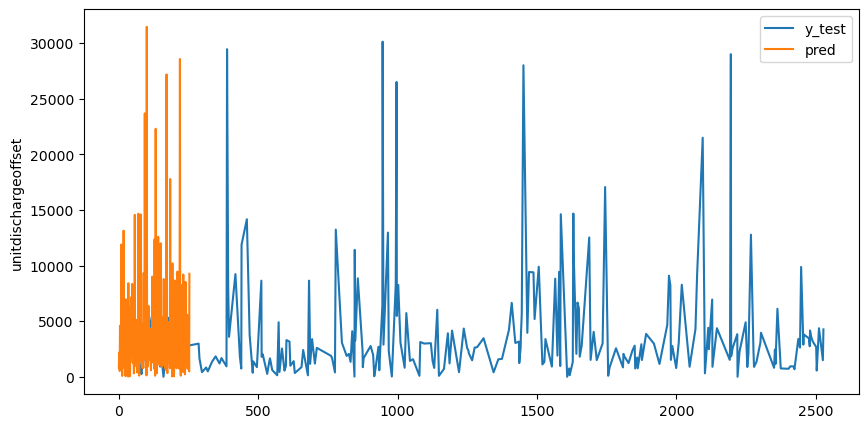

In [108]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

sns.lineplot(data=y_test, label="y_test", ax=ax)
sns.lineplot(data=pred, label="pred", ax=ax)